In [ ]:
#pip install --upgrade networkx


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
import matplotlib.pyplot as plt
import time
import psutil

# Define the graph for the Traveling Salesman Problem (TSP)
# Each edge represents a path between two cities with an associated distance
edges = [(0, 1, 10), (0, 2, 15), (0, 3, 20), (1, 2, 35), (1, 3, 25), (2, 3, 30)]

# Define the mapping from city indices to labels
city_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
print(city_labels)

# Define distances between cities for calculating total distance
distances = {
    ('A', 'B'): 10,
    ('A', 'C'): 15,
    ('A', 'D'): 20,
    ('B', 'C'): 35,
    ('B', 'D'): 25,
    ('C', 'D'): 30
}
graph = nx.Graph()
graph.add_weighted_edges_from(edges)

# Draw the graph with edge labels for distances
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title("Traveling Salesman Problem Graph")
plt.show()

# Start measuring time and memory
start_time = time.time()
process = psutil.Process()

# Define the number of qubits (cities) and the range of wires
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)

# Define the cost and mixer Hamiltonians for the QAOA algorithm
cost_h, mixer_h = qaoa.maxcut(graph)

# Define the number of QAOA layers
num_qaoa_layers = 2  # Adjust this value as needed

# Define the QAOA layers
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

# Define the complete QAOA circuit
def circuit(params):
    for w in wires:
        qml.Hadamard(wires=w)
    for i in range(num_qaoa_layers):
        qaoa_layer(params[i][0], params[i][1])

# Initialize the quantum device for simulation
dev = qml.device('default.qubit', wires=len(wires))

# Define the cost function for optimization
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

# Initialize the optimizer with a specific learning rate
learning_rate = 0.01
optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
steps = 200
params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

# Optimize the parameters to minimize the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters: ", params)

# Add measurement to get the probabilities of each bitstring
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=wires)

# Get the probabilities of each bitstring
probabilities = probability_circuit(params)

# Stop measuring time and memory
end_time = time.time()
memory_usage = process.memory_info().rss / 1024  # memory usage in KB

# Plot the quantum probabilities distribution for bitstrings
plt.bar(range(2 ** num_nodes), probabilities)
plt.title("Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Probability")
plt.show()

# Visualize the quantum circuit
#print(qml.draw(circuit, expansion_strategy='device')(params))

# Decode the most probable bitstring into a path
most_probable_bitstring = np.argmax(probabilities)
print("\nMost probable bitstring: " +str(most_probable_bitstring))
path_indices = [int(bit) for bit in format(most_probable_bitstring, '0' + str(num_nodes) + 'b')]
print("Binary or State Representation: "+str(path_indices))
print("Where the digits coorespond to the first two path choices: [A,B,C,D]")
# Determine the order of cities from the bitstring

if sum(path_indices) != 2:
    raise ValueError('Not All Cities Visited')
    
# Placeholder for actual TSP decoding process
tour_indices = [i for i, bit in enumerate(path_indices) if bit == 1]

# Start city is 'A', index 0
start_city_index = 0
start_city_label = 'A'

# Ensure the start city is the first in the tour
if start_city_index not in tour_indices:
    tour_indices.insert(0, start_city_index)

# Check if all cities are visited, if not, add the missing city
all_cities = set(range(num_nodes))
visited_cities = set(tour_indices)
if all_cities != visited_cities:
    missing_city = list(all_cities - visited_cities)[0]
    # Check if the missing city connects to the last city in the current path
    if (tour_indices[-1], missing_city) in graph.edges():
        tour_indices.append(missing_city)

# Ensure the tour is a cycle by returning to the start
if tour_indices[-1] != start_city_index:
    tour_indices.append(start_city_index)

# Decode the tour indices into city labels
decoded_tour = [city_labels[index] for index in tour_indices]
    
# Calculate the total distance of the path
shortest_distance = 0
for i in range(len(decoded_tour) - 1):
    edge = tuple(sorted((decoded_tour[i], decoded_tour[i + 1])))
    shortest_distance += distances[edge]

# Close the tour by returning to the start city 'A'
if decoded_tour[-1] != 'A':
    edge = tuple(sorted((decoded_tour[-1], 'A')))
    shortest_distance += distances[edge]
    decoded_tour.append('A')


#print(decoded_tour)

# Print out the results with descriptive statements
print(f"\n\nThe shortest path starting from city '{start_city_label}' is: {' -> '.join(decoded_tour)}")
print(f"The total distance of the shortest path is: {shortest_distance} units.")
# Print out the runtime and memory usage
print(f"\n\nRuntime of the code: {end_time - start_time} seconds")
print(f"Memory usage: {memory_usage} KB")

City Labels: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


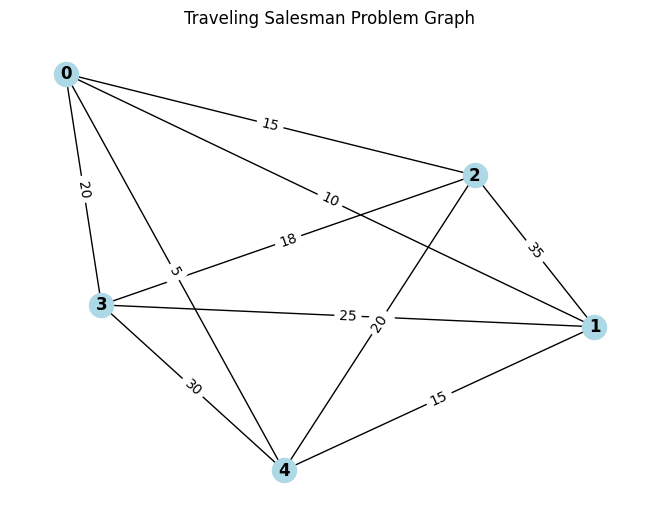

ValueError: PauliY: wrong number of wires. 5 wires given, 1 expected.

In [13]:
import pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
import matplotlib.pyplot as plt
import time
import psutil

# Define the graph for the Traveling Salesman Problem (TSP)
# Each edge represents a path between two cities with an associated distance
distance_matrix = np.array([
    [0, 10, 15, 20, 5],
    [10, 0, 35, 25, 15],
    [15, 35, 0, 18, 20],
    [20, 25, 18, 0, 30],
    [5, 15, 20, 30, 0]
])

# Create the graph from the distance matrix

graph = nx.from_numpy_array(distance_matrix)

# Extract city labels (assuming they correspond to node indices)
city_labels = {i: str(i) for i in range(len(distance_matrix))}
print("City Labels:", city_labels)

# Draw the graph with edge labels for distances
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title("Traveling Salesman Problem Graph")
plt.show()

# Start measuring time and memory
start_time = time.time()
process = psutil.Process()

# Define the number of qubits (cities) and the range of wires
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)

# Define the cost and mixer Hamiltonians for the QAOA algorithm
cost_h, mixer_h = qaoa.maxcut(graph)

# Define the number of QAOA layers
num_qaoa_layers = 2  # Adjust this value as needed

# Define the QAOA layers
def qaoa_layer(gamma, alpha):
  qaoa.cost_layer(gamma, cost_h)
  qaoa.mixer_layer(alpha, mixer_h)
    
# Assuming your circuit uses 5 qubits
wires = range(5)  # Create a list of 5 qubits

# Define the complete QAOA circuit
def circuit(params):
  for w in wires:
    qml.Hadamard(wires=w)
  for i in range(num_qaoa_layers):
    qaoa_layer(params[i][0], params[i][1])

# Initialize the quantum device for simulation
dev = qml.device('default.qubit', wires=len(wires))

# Assuming your circuit uses the same number of qubits as nodes in the graph
wires = range(num_nodes)  # Create a list of qubits with length num_nodes

def cost_function(params):
    circuit(params)
    # Create the cost operation with correct dimensions (negative distance matrix)
    cost_op = qml.PauliY(wires=wires)  # Assuming cost is sum of Pauli-Y on all qubits
    return qml.expval(cost_op, wires=wires)

# Initialize the optimizer with a specific learning rate
learning_rate = 0.01
optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
steps = 200
params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

# Optimize the parameters to minimize the cost function (maximize total distance)
for i in range(steps):
  params = optimizer.step(cost_function, params)

print("Optimal Parameters:", params)

# Add measurement to get the probabilities of each bitstring
@qml.qnode(dev)
def probability_circuit(params):
  circuit(params)
  return qml.probs(wires=wires)

# Get the probabilities of each bitstring
probabilities = probability_circuit(params)

# Stop measuring time and memory
end_time = time.time()
memory_usage = process.memory_info().rss / 1024  # memory usage in KB

# Plot the quantum probabilities distribution for bitstrings
plt.bar(range(2 ** num_nodes), probabilities)
plt.title("Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Probability")


City Labels: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


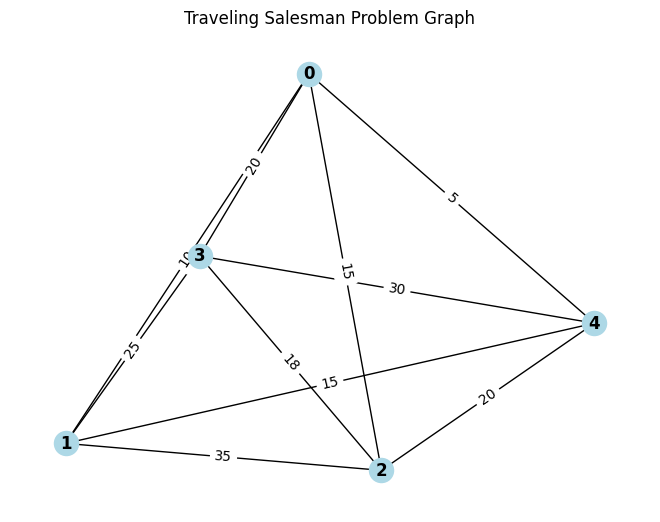

In [21]:
import pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
import matplotlib.pyplot as plt
import time
import psutil

# Define the graph for the Traveling Salesman Problem (TSP)
# Each edge represents a path between two cities with an associated distance
distance_matrix = np.array([
    [0, 10, 15, 20, 5],
    [10, 0, 35, 25, 15],
    [15, 35, 0, 18, 20],
    [20, 25, 18, 0, 30],
    [5, 15, 20, 30, 0]
])

# Create the graph from the distance matrix

graph = nx.from_numpy_array(distance_matrix)

# Extract city labels (assuming they correspond to node indices)
city_labels = {i: str(i) for i in range(len(distance_matrix))}
print("City Labels:", city_labels)

# Draw the graph with edge labels for distances
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title("Traveling Salesman Problem Graph")
plt.show()

# Start measuring time and memory
start_time = time.time()
process = psutil.Process()

# Define the number of qubits (cities) and the range of wires
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)

# Define the cost and mixer Hamiltonians for the QAOA algorithm
cost_h, mixer_h = qaoa.maxcut(graph)

# Define the number of QAOA layers
num_qaoa_layers = 2  # Adjust this value as needed

In [23]:
# Define the QAOA layers
def qaoa_layer(gamma, alpha):
  qaoa.cost_layer(gamma, cost_h)
  qaoa.mixer_layer(alpha, mixer_h)
    
# Define the number of nodes (based on distance matrix dimensions)
num_nodes = len(distance_matrix)

# Assuming num_nodes is defined correctly
# Initialize parameters for all qubits
params = pennylane.init.randopt(2 * num_nodes)  # Initialize parameters for all qubits

def circuit(params):
    
    for w in range(num_nodes):
        # Apply single-qubit rotations using parameters (e.g., Ry, Rz)
        qml.RY(params[w * 2], wires=w)
        qml.RZ(params[w * 2 + 1], wires=w)

        # Add entangling gates between qubits (e.g., CNOT)
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                qml.CNOT(wires=[i, j])

# Initialize the quantum device for simulation
dev = qml.device('default.qubit', wires=len(wires))

# Assuming your circuit uses the same number of qubits as nodes in the graph


wires = range(num_nodes)  # Create a list of qubits

# Option 1: Cost function with loop (assuming cost is sum of PauliY on all qubits)
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    cost_op = qml.sum([qml.PauliY(w) for w in wires])
    return qml.expval(cost_op)

# Initialize the optimizer with a specific learning rate
learning_rate = 0.01
optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
steps = 200
params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

# Optimize the parameters to minimize the cost function (maximize total distance)
for i in range(steps):
  params = optimizer.step(cost_function, params)

print("Optimal Parameters:", params)

# Add measurement to get the probabilities of each bitstring
@qml.qnode(dev)
def probability_circuit(params):
  circuit(params)
  return qml.probs(wires=wires)

# Get the probabilities of each bitstring
probabilities = probability_circuit(params)

# Stop measuring time and memory
end_time = time.time()
memory_usage = process.memory_info().rss / 1024  # memory usage in KB

# Plot the quantum probabilities distribution for bitstrings
plt.bar(range(2 ** num_nodes), probabilities)
plt.title("Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Probability")

AttributeError: module 'pennylane' has no attribute 'init'